<a href="https://www.kaggle.com/code/ashioyajotham/financial-inclusion-in-africa?scriptVersionId=111060151" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fininclusionafrica/SampleSubmission.csv
/kaggle/input/fininclusionafrica/Train.csv
/kaggle/input/fininclusionafrica/VariableDefinitions.csv
/kaggle/input/fininclusionafrica/Test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from category_encoders import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline

In [3]:
train = pd.read_csv("../input/fininclusionafrica/Train.csv")
test = pd.read_csv("../input/fininclusionafrica/Test.csv")
var = pd.read_csv("../input/fininclusionafrica/VariableDefinitions.csv")
sample = pd.read_csv("../input/fininclusionafrica/SampleSubmission.csv")

In [4]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
train.columns

Index(['country', 'year', 'uniqueid', 'bank_account', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type'],
      dtype='object')

In [6]:
# Change the order of the columns so that "uniqueid" comes first

#train = train.reindex(['uniqueid', 'country', 'year', 'bank_account', 'location_type',
      # 'cellphone_access', 'household_size', 'age_of_respondent',
      # 'gender_of_respondent', 'relationship_with_head', 'marital_status',
      # 'education_level', 'job_type'], axis = 1)
#train.tail()

### Or simply...

In [7]:
train = train[['country', 'year', 'uniqueid', 'bank_account', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


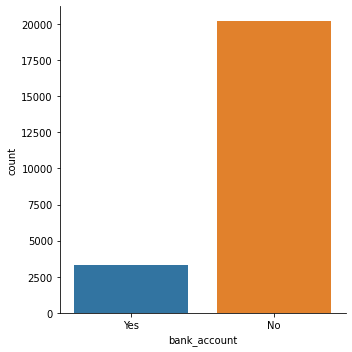

In [9]:
# Target distribuution
sns.catplot(x="bank_account", kind="count", data=train);

## Check for Outliers

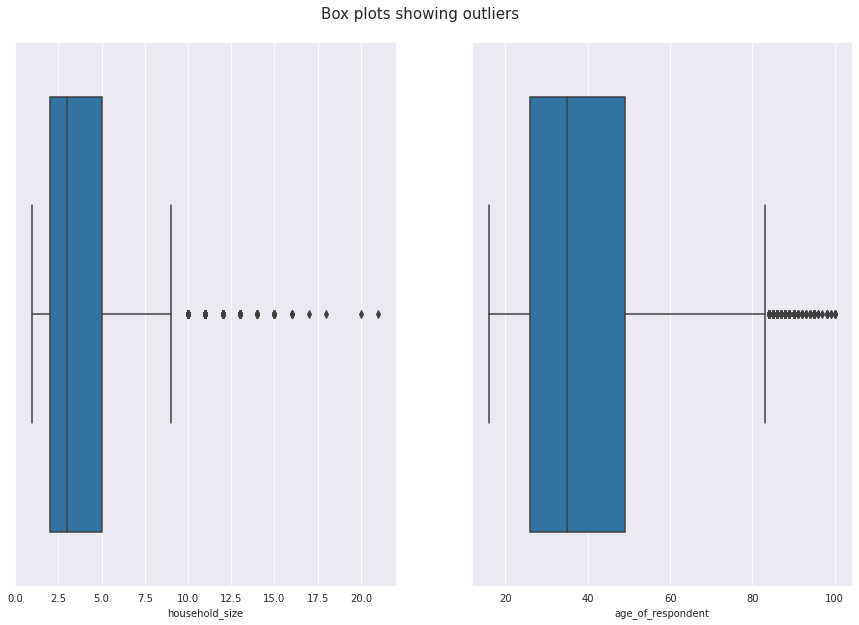

In [10]:
# Plotting boxplots for each of the numerical columns
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['household_size', 
                                                  'age_of_respondent']):
  sns.boxplot(train[name], ax = ax)

### Outlier Treatment

In [11]:
train["household_size"].describe()

count    23524.000000
mean         3.797483
std          2.227613
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         21.000000
Name: household_size, dtype: float64

In [12]:
# Quantile flooring and capping
print(train["household_size"].quantile(.10))
print(train["household_size"].quantile(.90))

1.0
7.0


In [13]:
train["household_size"] = np.where(train["household_size"]<1.0, 1.0, train["household_size"])
train["household_size"] = np.where(train["household_size"]>7.0, 7.0, train["household_size"])
print(train["household_size"].skew())

0.3413724521126838


In [14]:
index = train[(train["household_size"]>=21.000000)|(train["household_size"]<=1.000000)].index
train.drop(index, inplace=True)
train["household_size"].describe()

count    20467.000000
mean         4.066058
std          1.741064
min          2.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: household_size, dtype: float64

Text(0.5, 1.0, 'Household Size Distribution')

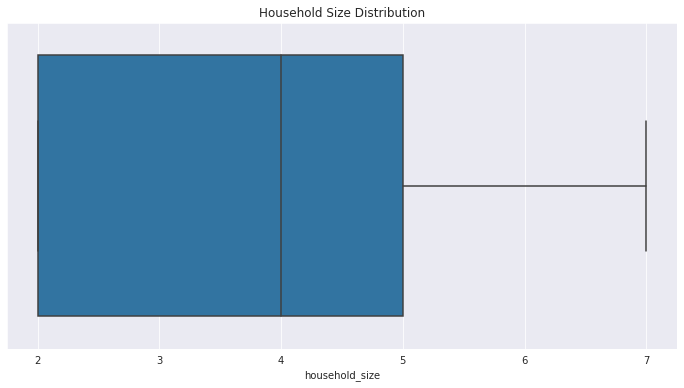

In [15]:
# Now let us look at our data after outlier treatment
plt.figure(figsize=(12, 6))
sns.boxplot(train["household_size"])
plt.title('Household Size Distribution')

In [16]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3.0,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5.0,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5.0,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5.0,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,7.0,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [17]:
# Change household to "int" type
train = train.astype({"household_size": "int"})
print(train["household_size"].dtype)

int64


In [18]:
train["country"].value_counts()

Rwanda      8260
Tanzania    5215
Kenya       5065
Uganda      1927
Name: country, dtype: int64

##### TODOs
* Feature engineer region/cities

## Check for Low- and -High Cardinality Categorical Variables
* A categorical feature is said to possess `high cardinality` when there are too many of these unique values. One-Hot Encoding becomes a big problem in such a case since we have a separate column for each unique value (indicating its presence or absence) in the categorical variable which leads to `curse of dimensionality`
[More info](https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b)

In [19]:
train.select_dtypes("object").head()

,country,uniqueid,bank_account,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,uniqueid_1,Yes,Rural,Yes,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,uniqueid_2,No,Rural,No,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,uniqueid_3,Yes,Urban,Yes,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,uniqueid_4,No,Rural,Yes,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,uniqueid_5,No,Urban,No,Male,Child,Single/Never Married,Primary education,Informally employed


In [20]:
train.select_dtypes("object").nunique() # ie the cardinality

country                      4
uniqueid                  8584
bank_account                 2
location_type                2
cellphone_access             2
gender_of_respondent         2
relationship_with_head       6
marital_status               5
education_level              6
job_type                    10
dtype: int64

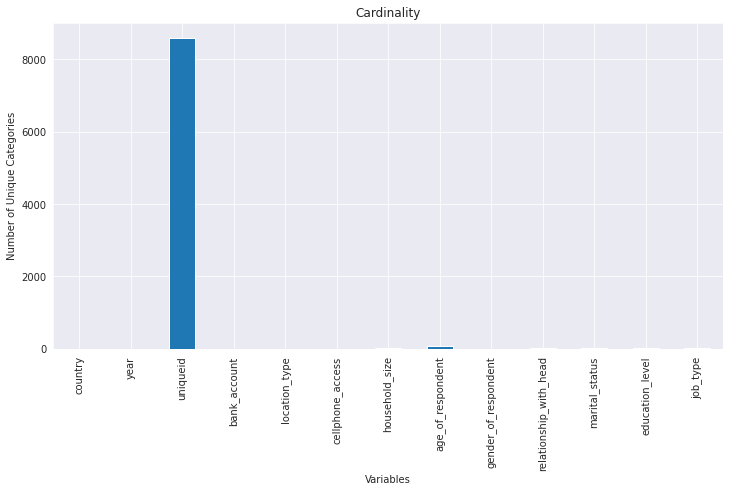

In [21]:
train.nunique().plot.bar(figsize=(12,6))
plt.ylabel("Number of Unique Categories")
plt.xlabel("Variables")
plt.title("Cardinality");

* If the cardinality is too high you can decide to drop the entire column or use the sample function below to minimise.

In [22]:
#absfrom collections import Counter
#def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  #threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  #categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  #s=0
  #Create a counter dictionary of the form unique_value: frequency
  #counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  #for i,j in counts.most_common():
    #Add the frequency to the global sum
    #s+=dict(counts)[i]
    #Append the category name to the list
    #categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    #if s>=threshold_value:
      #break
  #Append the category Other to the list
  #categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  #new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  #Return transformed column and unique values if return_categories=True
  #if(return_categories_list):
    #return new_column,categories_list
  #Return only the transformed column if return_categories=False
  #else:
    #return new_column


#Call the function with a default threshold of 75%
#transformed_column,new_category_list=cumulatively_categorise(data['Qualification'],return_categories_list=True)


#transformed_column.describe()

## Check for multicollinearity

In [23]:
train["year"] = train["year"].astype("object")

In [24]:
corr = train.select_dtypes("number").corr()
corr

,household_size,age_of_respondent
household_size,1.000000,-0.078646
age_of_respondent,-0.078646,1.000000


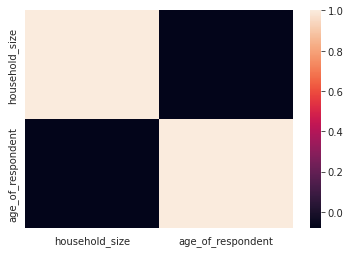

In [25]:
sns.heatmap(corr);

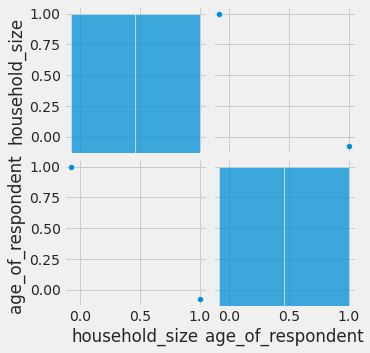

In [26]:
plt.style.use("fivethirtyeight")
sns.pairplot(corr);

## Visualization

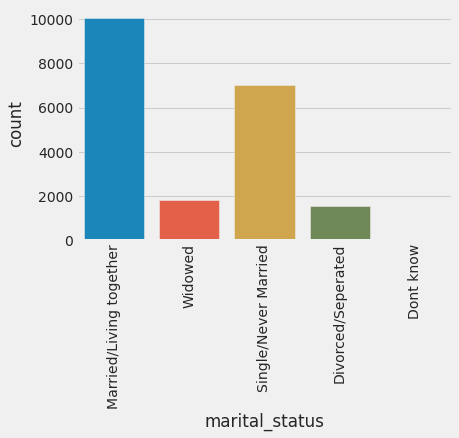

In [27]:
sns.countplot(train["marital_status"])
plt.xticks(rotation = "vertical");

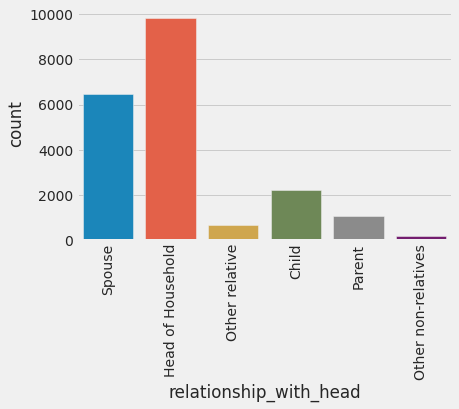

In [28]:
sns.countplot(train["relationship_with_head"])
plt.xticks(rotation = "vertical");

##### Marital Status Exploration

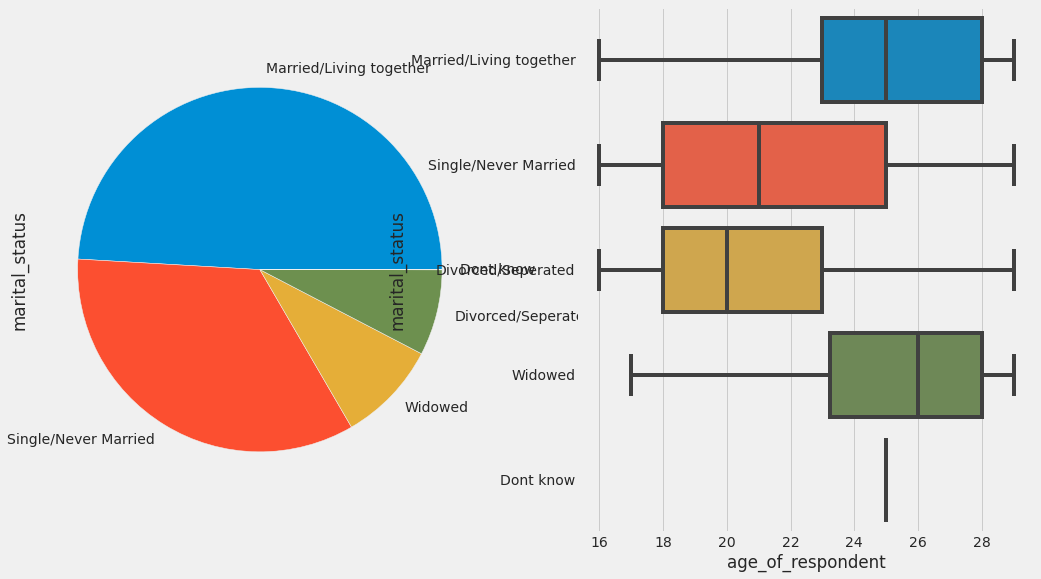

In [29]:
_,ax = plt.subplots(1,2,figsize=(16,9))
train.marital_status.value_counts().plot.pie(ax=ax[0])
sns.boxplot(data=train.query("age_of_respondent<30"), y='marital_status', 
            x='age_of_respondent', ax=ax[1]);

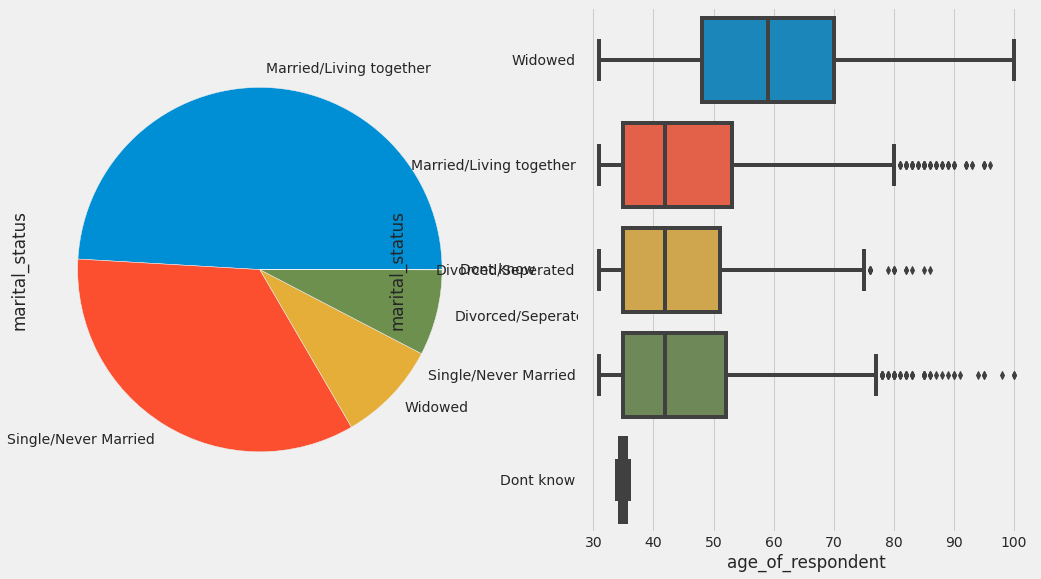

In [30]:
_,ax = plt.subplots(1,2,figsize=(16,9))
train.marital_status.value_counts().plot.pie(ax=ax[0])
sns.boxplot(data=train.query("age_of_respondent>30"), y='marital_status', 
            x='age_of_respondent', ax=ax[1]);

In [31]:
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [32]:
test.isnull().any()

country                   False
year                      False
uniqueid                  False
location_type             False
cellphone_access          False
household_size            False
age_of_respondent         False
gender_of_respondent      False
relationship_with_head    False
marital_status            False
education_level           False
job_type                  False
dtype: bool

In [33]:
test["year"] = test["year"].astype("object")

## Modelling

In [34]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,7,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [35]:
target = "bank_account"
features = ["year", "location_type", "country", "cellphone_access", "household_size", "age_of_respondent",
           "household_size", "gender_of_respondent", "relationship_with_head", "marital_status",
           "education_level", "job_type"]

# Convert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

X = train[features]
y = train[target]

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 20467, dtype: int64


In [36]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)
    
    # categorical features to be converted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
    
    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    
    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
   
    return data                  

In [37]:
# preprocess the train data 
processed_train = preprocessing_data(X_train)
processed_test = preprocessing_data(test)

# the first train row
print(processed_train[:1])

[[1.        0.        1.        0.2       0.0952381 0.        0.
  0.        0.        0.        0.        1.        0.        0.
  1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.       ]]


In [38]:
# shape of the processed train set
print(processed_train.shape)

(20467, 37)


In [39]:
X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train, 
                                                  test_size = 0.1, random_state=42)

* The parameter `stratify = y_train` ensures an equal balance of values from both classes ("yes" and "no") for both train and validation sets.

### Baseline Model

In [40]:
# Linear model
lg_model = LogisticRegression()

# Fit model
lg_model.fit(X_Train, y_Train)

lg_y_pred = lg_model.predict(X_Val)

print("Error rate of Linear model classifier: ", 1 - accuracy_score(y_val, lg_y_pred))

Error rate of Linear model classifier:  0.11284807034684907


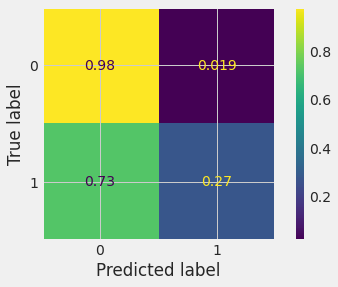

In [41]:
plot_confusion_matrix(lg_model,X_Val, y_val,normalize='true');

In [42]:
# Random Forest Classifier
rf_model = RandomForestClassifier()

# Fit the model
rf_model.fit(X_Train, y_Train)

rf_y_pred = rf_model.predict(X_Val)

print("Error rate of random forest classifier is ", 1 -  accuracy_score(y_val, rf_y_pred))

Error rate of random forest classifier is  0.11822178798241334


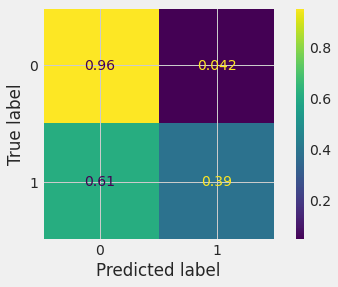

In [43]:
plot_confusion_matrix(rf_model, X_Val, y_val, normalize = "true");

In [44]:
# K - Nearest Neighbours
kn_model = KNeighborsClassifier()

# Fit the model
kn_model.fit(X_Train, y_Train)

kn_y_pred = kn_model.predict(X_Val)

print("Error rate of random forest classifier is ", 1 -  accuracy_score(y_val, kn_y_pred))

Error rate of random forest classifier is  0.11480214948705425


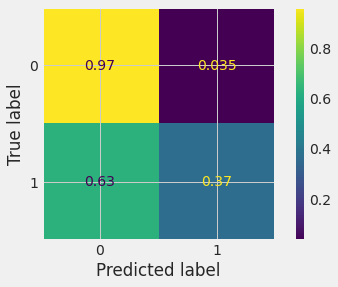

In [45]:
plot_confusion_matrix(kn_model, X_Val, y_val, normalize = "true"); 

In [46]:
# Extra trees
et_model = ExtraTreesClassifier()

# Fit the model
et_model.fit(X_Train, y_Train)

et_y_pred = et_model.predict(X_Val)

print("The error rate of our extra trees model is ", 1 - accuracy_score(y_val, et_y_pred))

The error rate of our extra trees model is  0.1284807034684905


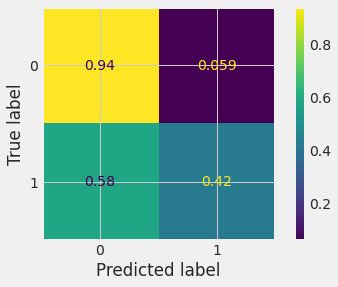

In [47]:
plot_confusion_matrix(et_model, X_Val, y_val, normalize = "true");

In [48]:
# create model
xg_model = XGBClassifier()

# fit the model
xg_model.fit(X_Train, y_Train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [49]:
xg_y_pred = xg_model.predict(X_Val)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, xg_y_pred))

Error rate of XGB classifier:  0.10796287249633607


In [50]:
accuracy = accuracy_score(y_val, xg_y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.20%


* This means the lower the incorrect percentage we get, the better the model performance

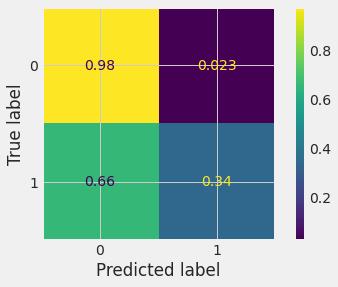

In [51]:
# Get confusion matrix for Gradient Boosting Classifier
plot_confusion_matrix(xg_model,X_Val, y_val,normalize='true');

In [52]:
# Get the predicted result for the test Data
test.bank_account = xg_model.predict(processed_test)

# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

submission.sample(5)

,uniqueid,bank_account
3908,uniqueid_10043 x Rwanda,0
6976,uniqueid_7251 x Tanzania,0
9817,uniqueid_2734 x Uganda,0
8145,uniqueid_8420 x Tanzania,0
2246,uniqueid_8315 x Kenya,0


In [53]:
#submission.to_csv('one.csv', index = False)
#files.download('one.csv') # to download directly

* From the confusion matrix, we have noticed is that our model performs poorly on 0 and very good on 1. 
* One way to increase the model's performance is through the `Grid Search Method` which methodically builds and evaluates a model for each combo of algorithms parameters specified in a parameter

### Parameter Tuning

In [54]:
# Optimize model parameters
#param_grid = {
    #"min_child_weight": [1,5,10],
    #"gamma": [0.5, 1],
    #"subsample": [0.6, 0.8, 1.0],
    #"max_depth": [3, 5]
#}

#xgb_model = GridSearchCV(xg_model, param_grid, n_jobs = -1, verbose = 2, cv = 5)
#xgb_model.fit(X_Train, y_Train)
#print(xgb_model.best_params_)

In [55]:
xgb_model = XGBClassifier(min_child_weight = 10, gamma = 0.5, subsample = .6, max_depth = 3)

xgb_model.fit(X_Train, y_Train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [56]:
y_pred = xgb_model.predict(X_Val)

# Get error rate
print("Error rate of the XGB classifier: ", 1 - accuracy_score(y_val, y_pred))

Error rate of the XGB classifier:  0.10503175378602836


### TODOs:

### Evaluate XGBoost Models with k-Fold Cross Validation
* Cross validation is an approach that you can use to estimate the performance of a machine learning algorithm with less variance than a single train-test set split.
* It works by splitting the dataset into k-parts (e.g. k=5 or k=10). Each split of the data is called a fold. The algorithm is trained on k-1 folds with one held back and tested on the held back fold. This is repeated so that each fold of the dataset is given a chance to be the held back test set.
* After running cross validation you end up with k different performance scores that you can summarize using a mean and a standard deviation. 
* The result is a more reliable estimate of the performance of the algorithm on new data given your test data. It is more accurate because the algorithm is trained and evaluated multiple times on different data.[Read more](https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/)

In [57]:
# Get the predicted result for the test data
test.bank_account = xgb_model.predict(processed_test)

# Create a submission df
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})
submission.sample(5)

,uniqueid,bank_account
777,uniqueid_6846 x Kenya,0
842,uniqueid_6911 x Kenya,0
333,uniqueid_6402 x Kenya,0
7621,uniqueid_7896 x Tanzania,0
2090,uniqueid_8159 x Kenya,0


In [58]:
#submission.to_csv("one_v3.csv", index = False)

### Feature importance

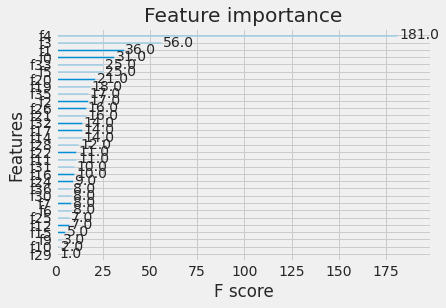

<Figure size 1296x1440 with 0 Axes>

In [59]:
xgb.plot_importance(xgb_model)
plt.figure(figsize = (18, 20))
plt.show();

In [60]:
# Save model
import joblib

joblib.dump(xgb_model, "fin-inclusion.pkl")

['fin-inclusion.pkl']

In [61]:
#install a package to change model into actual code
!pip install m2cgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 991.6 kB/s eta 0:00:00a 0:00:01


In [62]:
#load model to convert into python 
import joblib 

model = joblib.load("fin-inclusion.pkl")

In [63]:
#convert model into python code 
import m2cgen as m2c 
model_to_python = m2c.export_to_python(model)

In [64]:
# show python code 
#open text file
text_file = open("model.txt", "w")

#write string to file
text_file.write(model_to_python)

#close file
text_file.close()